In [ ]:
#Light weight CNN for kidney cancer detection
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/data.zip","r")
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import math
import random
import os
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [ ]:
# count the number of images in the respective classes 1 - tumor and 0 - Normal
ROOT_DIR ="/content/data/"

In [ ]:
splitfolders.ratio(ROOT_DIR,output="splited_data",
                   seed=42,
                   ratio=(.7,.0,.3),
                   group_prefix=None)

Copying files: 7360 files [00:03, 2140.41 files/s]


In [ ]:
# generators
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/splited_data/train/",
    labels = "inferred",
    label_mode ="int",
    batch_size=16,
    image_size=(224,224)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/splited_data/test/",
    labels = "inferred",
    label_mode ="int",
    batch_size=16,
    image_size=(224,224)
)

Found 5151 files belonging to 2 classes.
Found 2209 files belonging to 2 classes.


In [ ]:
# Path to the folders containing the images
normal_folder = '/content/splited_data/train/Normal'
tumor_folder = '/content/splited_data/train/Tumor'

# Get the list of image filenames in the folders
normal_images = [os.path.join(normal_folder, filename) for filename in os.listdir(normal_folder)]
tumor_images = [os.path.join(tumor_folder, filename) for filename in os.listdir(tumor_folder)]

# Combine the lists of images
all_images = normal_images + tumor_images
random.shuffle(all_images)  # Shuffle the images

In [ ]:
# Function to plot images
def plotImages(image_paths):
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    for img_path, ax in zip(image_paths, axes.ravel()):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(os.path.dirname(img_path)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

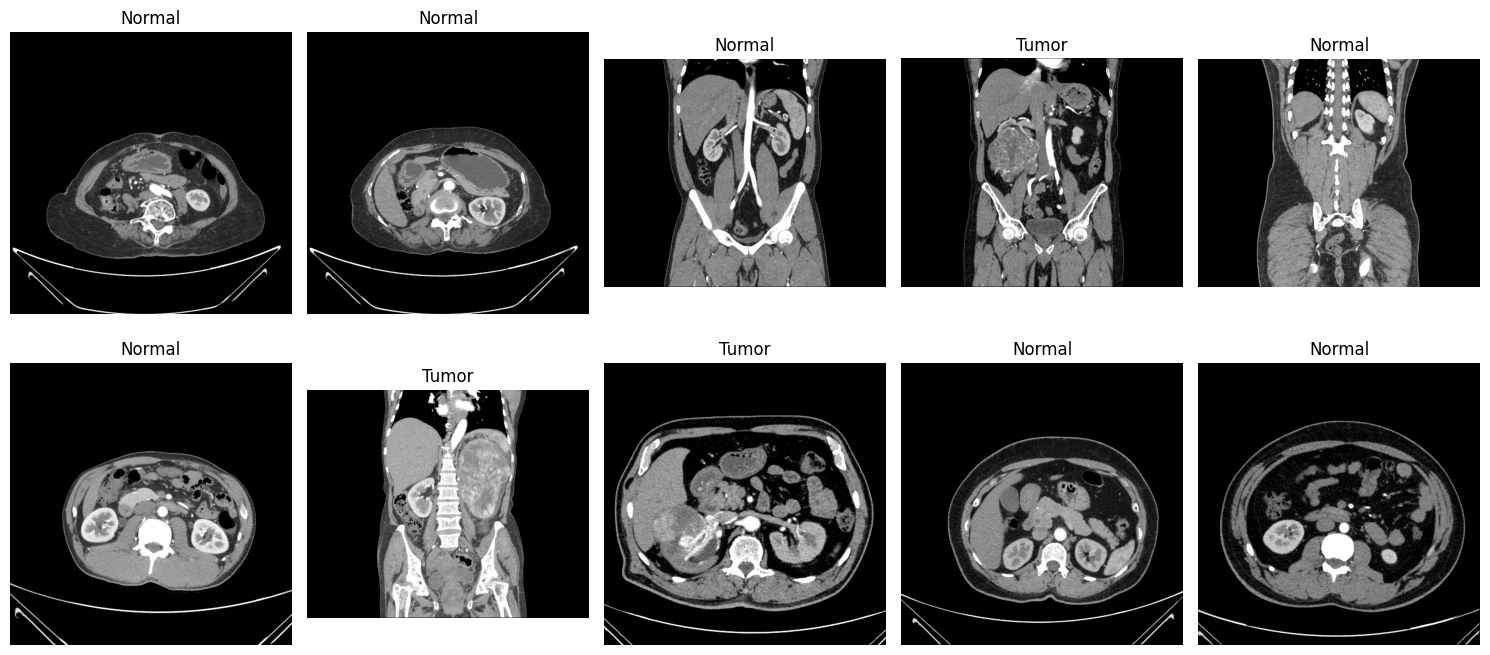

In [ ]:
# Select 10 random images
selected_images = random.sample(all_images, 10)

# Plot the selected images
plotImages(selected_images)

In [ ]:
def MobileNet(input_shape, num_classes):
    # Input layer
    input_tensor = Input(shape=input_shape)

    # Initial Convolution Block
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)

    # Depthwise Separable Convolution Blocks
    x = depthwise_separable_block(x, 64, (3, 3), alpha=1)
    x = depthwise_separable_block(x, 128, (3, 3), alpha=1, strides=(2, 2))
    x = depthwise_separable_block(x, 128, (3, 3), alpha=1)
    x = depthwise_separable_block(x, 256, (3, 3), alpha=1, strides=(2, 2))
    x = depthwise_separable_block(x, 256, (3, 3), alpha=1)
    x = depthwise_separable_block(x, 512, (3, 3), alpha=1, strides=(2, 2))

    # Classifier
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)  # Change num_classes to 1

    model = Model(input_tensor, x)
    return model


In [ ]:
# Define the input shape and number of classes
input_shape = (224, 224, 3)  # Adjust the input shape according to your dataset
num_classes = 2  # Binary classification (cancer or non-cancer)

# Create the MobileNet model
model = MobileNet(input_shape, num_classes)

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_14 (Ba  (None, 112, 112, 32)      128       
 tchNormalization)                                               
                                                                 
 re_lu_14 (ReLU)             (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_12 (Depth  (None, 112, 112, 32)      320       
 wiseConv2D)                                                     
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      2112

In [ ]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
322/322 [==============================] - 30s 92ms/step - loss: 0.0098 - accuracy: 0.9967 - precision: 0.9944 - recall: 0.9950 - val_loss: 0.0012 - val_accuracy: 0.9995 - val_precision: 0.9985 - val_recall: 1.0000
Epoch 2/10
322/322 [==============================] - 28s 85ms/step - loss: 0.0074 - accuracy: 0.9981 - precision: 0.9975 - recall: 0.9962 - val_loss: 0.0010 - val_accuracy: 0.9995 - val_precision: 1.0000 - val_recall: 0.9985
Epoch 3/10
322/322 [==============================] - 23s 71ms/step - loss: 8.6088e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.5736e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
322/322 [==============================] - 25s 76ms/step - loss: 4.7457e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.6073e-04 - val_accuracy: 0.9995 - val_precision: 1.0000 - val_recall: 0.9985
Epoch 5/10
322/322 [==============================] - 23s 70ms/step - loss: 1.68

In [ ]:
# Save the model
model_save_path = '/content/drive/MyDrive/model/mobilenet.h5'
model.save(model_save_path)

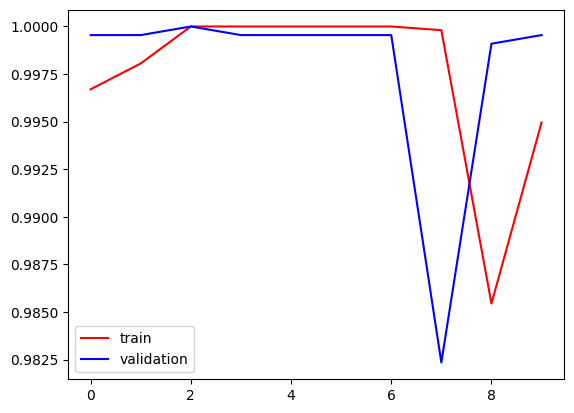

In [ ]:
plt.plot(history.history["accuracy"],color="red",label="train")
plt.plot(history.history['val_accuracy'],color="blue",label="validation")
plt.legend()
plt.show()

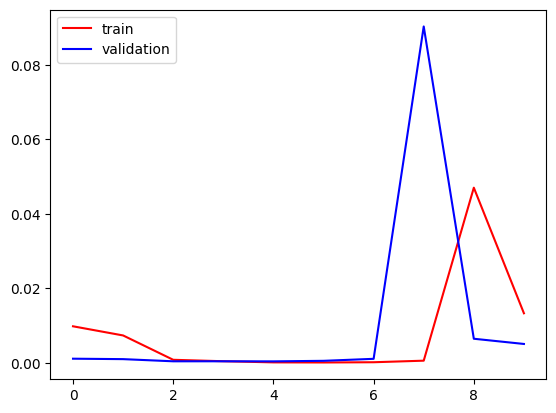

In [ ]:
plt.plot(history.history["loss"],color="red",label="train")
plt.plot(history.history['val_loss'],color="blue",label="validation")
plt.legend()
plt.show()

In [ ]:
# Load the saved model
model_path = '/content/drive/MyDrive/model/mobilenet.h5'
loaded_model = keras.models.load_model(model_path)

# Load an image for inference (adjust as needed)
# image_path = '/content/splited_data/test/Tumor/Tumor- (1008).jpg'
image_path = '/content/splited_data/test/Normal/Normal- (1000).jpg'
image = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Adjust target_size based on your model's input shape
image = tf.keras.utils.img_to_array(image)
image = tf.expand_dims(image, axis=0)  # Add batch dimension

# Perform inference
predictions = loaded_model.predict(image)

# Interpret the predictions
if predictions[0][0] < 0.5:
    result = "Normal"
else:
    result = "Cancerous"

# Print the result
print("The image is classified as:", result)


1/1 [==============================] - 0s 320ms/step
The image is classified as: Normal
